# Example aggregation analysis notebook
### Author: Bill Flynn (bill.flynn@jax.org)

Updates:
- 2018-12-31: creation
- 2019-04-02: update_1 (Martine seignon)

This notebook assumes you have some familiarity with the `scanpy_recipes` extensions.  If not, check out `examples/Analysis-Template.ipynb` for more details.  This will be an abbreviated notebook just showing how things work with an aggregated sample.

In [1]:
from scanpy_recipes import sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Running Scanpy 1.3.7 on 2019-04-03 13:55.


## Loading data

In [2]:
ac = sc.AnalysisConfig()

In [3]:
config_string = """
[names]
pi_name = Anonymous person
customer_name = Anonymous person
analyst_name = Bill Flynn
analysis_name = Test-analysis

[sample_names]
AJ17001 = LHA-Males
AJ17002 = LHA-Female

[genomes]
AJ17001 = mm10
AJ17002 = mm10

[species]
hg19 = hsapiens
GRCh38 = hsapiens
mm10 = mmusculus
mm-c57bl6nj = mmusculus
mm-casteij = mmusculus

[input_dirs]
AJ17001 = /fastscratch/seignm/singlecell/test_dataset/AJ17001/outs/
AJ17002 = /fastscratch/seignm/singlecell/test_dataset/AJ17002/outs/

[output_dirs]
AJ17001 = /fastscratch/seignm/singlecell/test_output
AJ17002 = /fastscratch/seignm/singlecell/test_output

[target_cells]
AJ17001 = 6000
AJ17002 = 6000

[10x_chemistry]
AJ17001 = v2
AJ17002 = v2

[cellranger_version]
AJ17001 = 2.2.0
AJ17002 = 2.2.0

[reference_version]
AJ17001 = 2.1.0
AJ17002 = 2.1.0

"""
config = ac.read(config_string)

Below, I'll be storing the adata objects in an iterable so that you can get the sense for how this might scale with many samples.

In [4]:
combined_sampleid = "AJ17001-AJ17002"
combined_sample_name = "LHA-Male/Female"
combined_output_dir = "/fastscratch/seignm/singlecell/test_output"

In [5]:
sampleids = config["sample_names"]

In [6]:
adata_raws = dict((sampleid, sc.load_10x_data(sampleid, config)) for sampleid in sampleids)

reading /fastscratch/seignm/singlecell/test_dataset/AJ17001/outs/filtered_gene_bc_matrices_h5.h5 

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


(0:00:01.30)
Ran `.var_names_make_unique()` for you.
reading /fastscratch/seignm/singlecell/test_dataset/AJ17002/outs/filtered_gene_bc_matrices_h5.h5 

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


(0:00:01.45)
Ran `.var_names_make_unique()` for you.


## Quality control and filtering

Analysis first starts by generating **per-cell** and **per-gene** metrics, that we can then use to filter the data.  We compute these before we do any aggregation

In [7]:
for adata_raw in adata_raws.values():
    sc.qc.gen_qc(adata_raw)

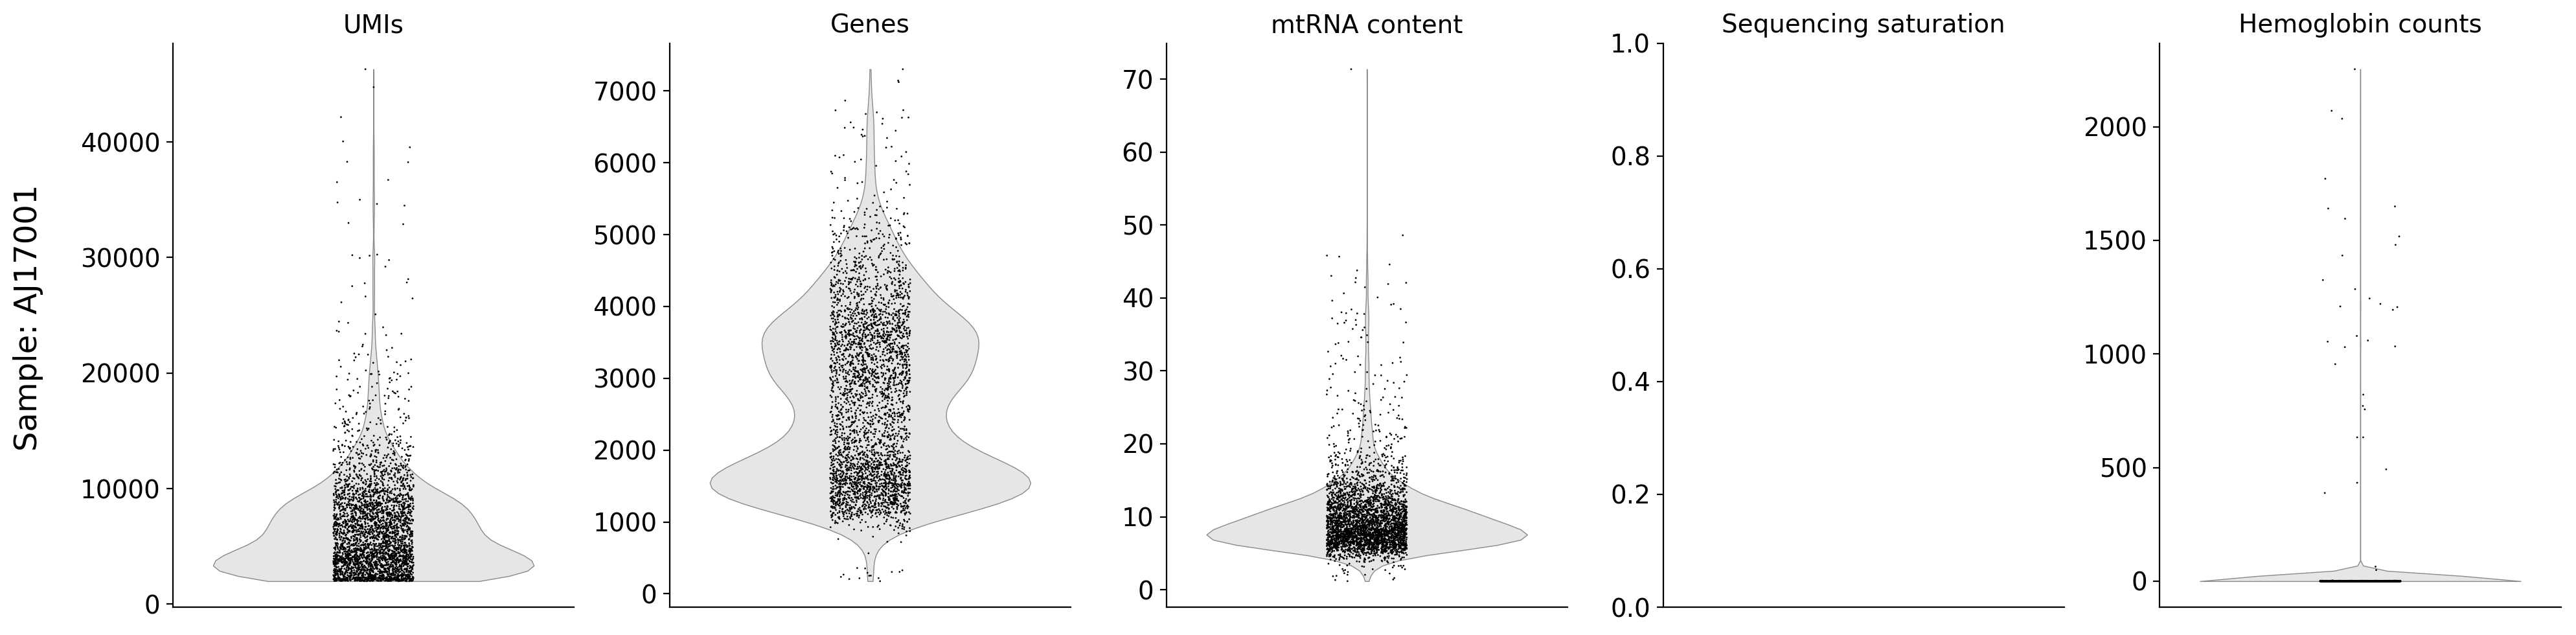

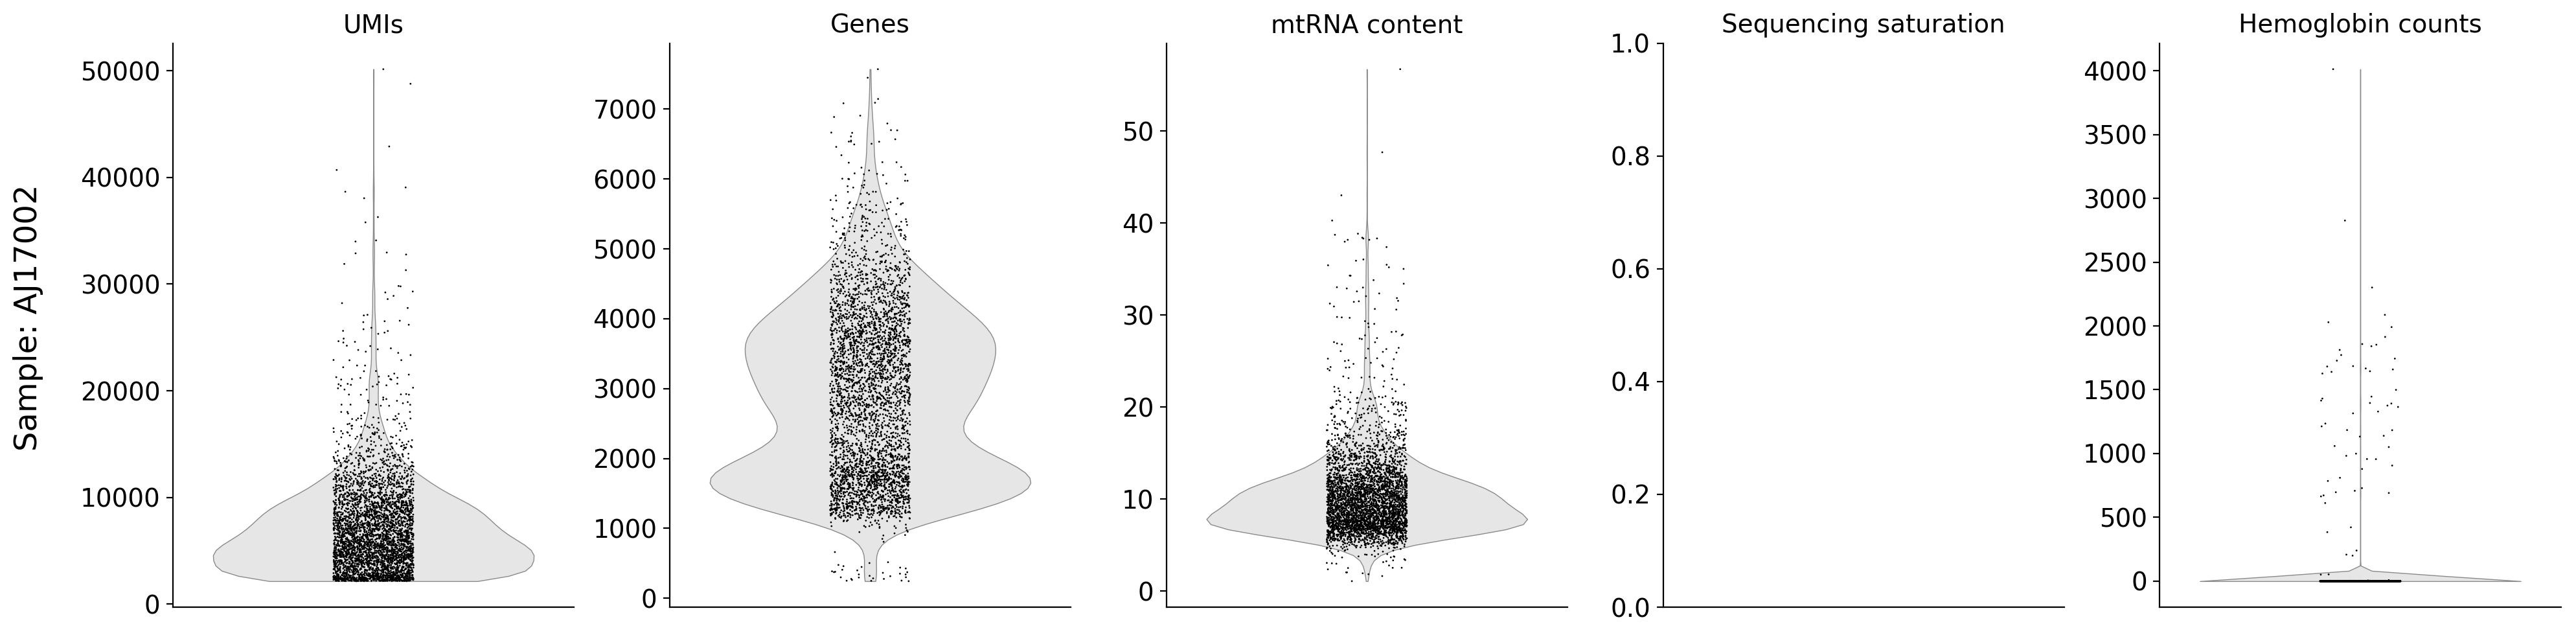

In [8]:
for adata_raw in adata_raws.values():
    sc.pl.qc_violins(adata_raw)

Either use one set of QC params that can be used for all samples or use individual params. Below is one way to do this. 
Note: min and/or max tresholds can be set for each parameter as needed.

In [9]:
qc_params = dict(
           min_cells_per_gene=3,
           min_counts_per_gene=3,
           min_genes_per_cell=200,
           max_genes_per_cell=8000,
           min_counts_per_cell=500,
           max_counts_per_cell=80000,
           max_pct_mitochondrial=30,
           max_counts_hemoglobin=2000
)
qc_params = dict((sampleid, qc_params.copy()) for sampleid in adata_raws.keys())

In [10]:
qc_params["AJ17001"].update(max_counts_hemoglobin=1500)

In [11]:
trials = [sc.qc.run_qc(adata_raw, trial=True, **qc_params[sampleid])
          for sampleid, adata_raw in adata_raws.items()]

filtered out 1 cells that have less than 200 genes expressed
filtered out 11421 genes that are detected in less than 3 cells
Original dims: (3439, 28692)
Filtered dims: (3377, 17271)
filtered out 11240 genes that are detected in less than 3 cells
Original dims: (3793, 28692)
Filtered dims: (3751, 17452)


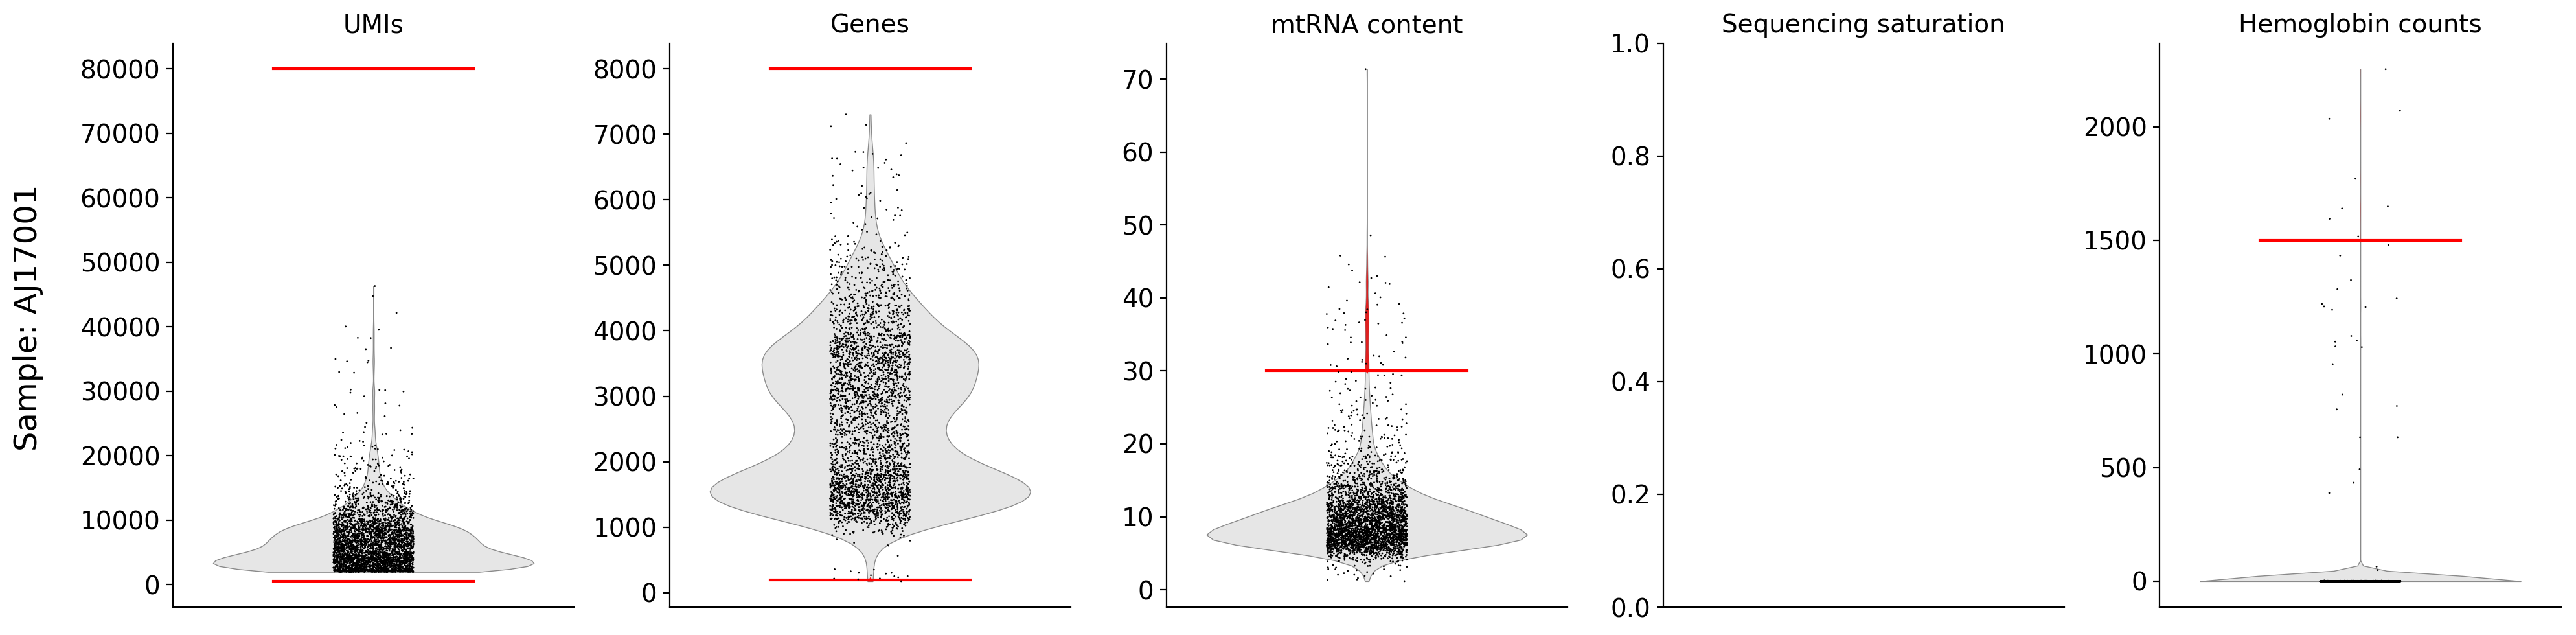

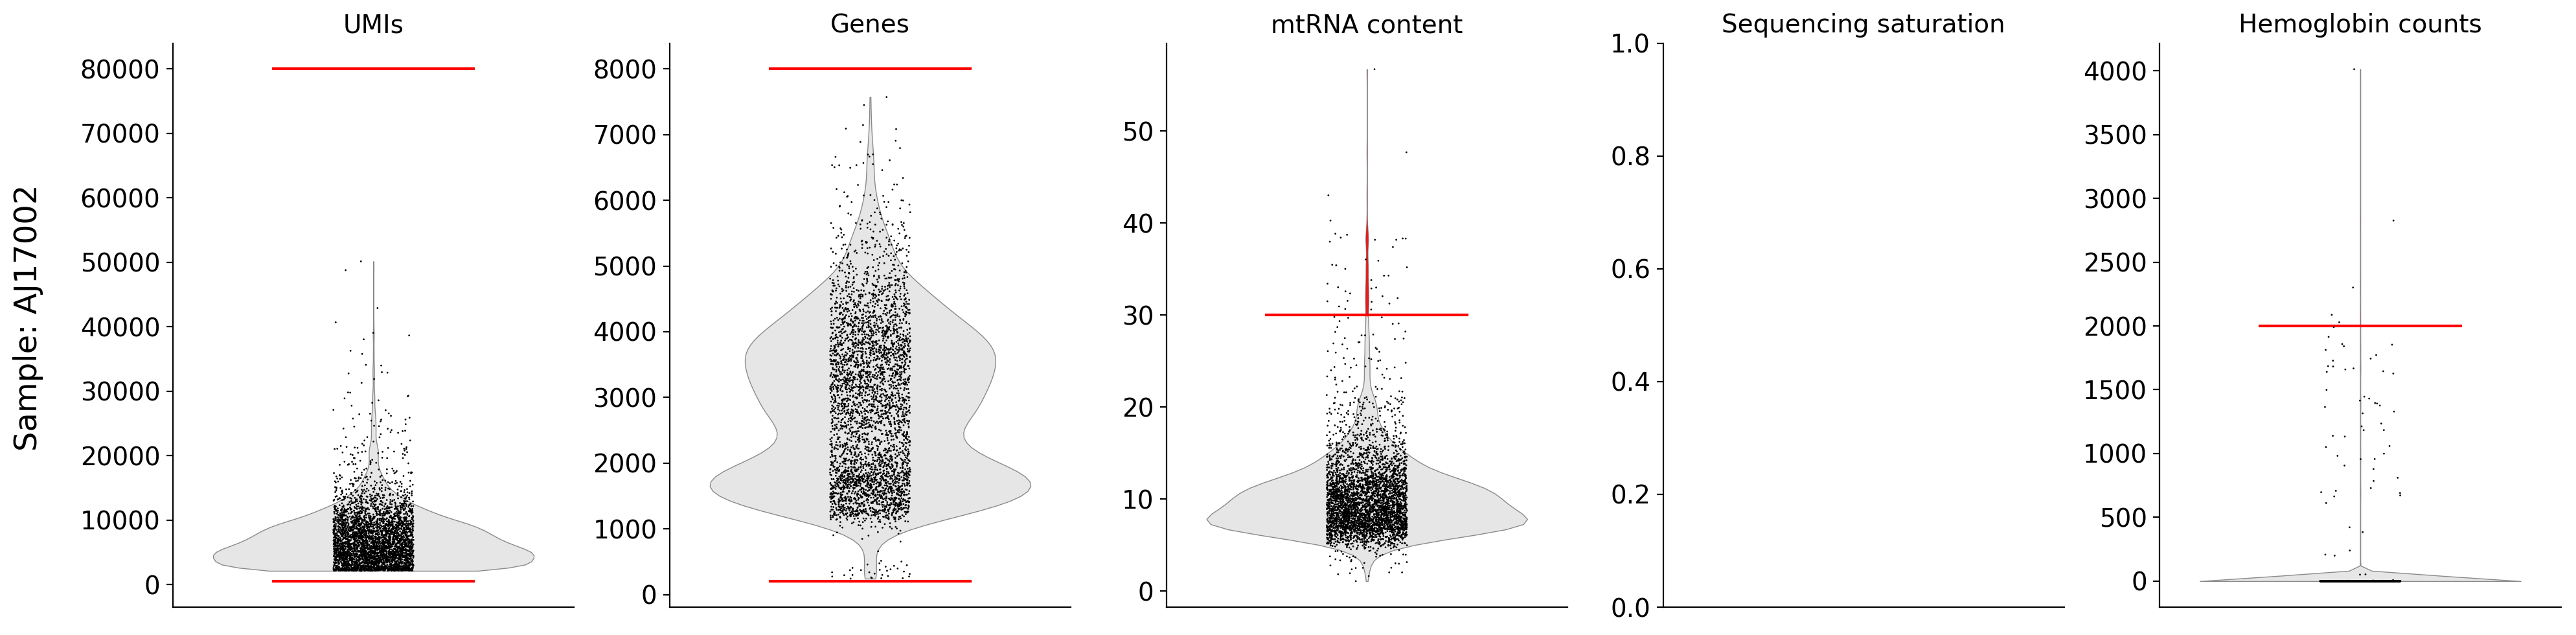

In [12]:
qc_figs = [sc.pl.qc_violins(trial, return_fig=True) for trial in trials]

In [13]:
adata_qcs = [sc.qc.run_qc(adata_raw, trial=False, **qc_params[sampleid])
             for sampleid, adata_raw in adata_raws.items()]

filtered out 1 cells that have less than 200 genes expressed
filtered out 11421 genes that are detected in less than 3 cells
Original dims: (3439, 28692)
Filtered dims: (3377, 17271)
filtered out 11240 genes that are detected in less than 3 cells
Original dims: (3793, 28692)
Filtered dims: (3751, 17452)


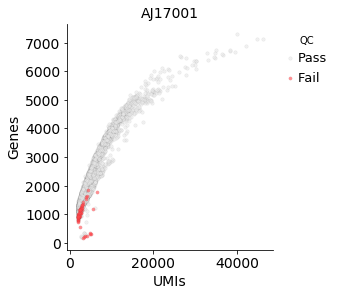

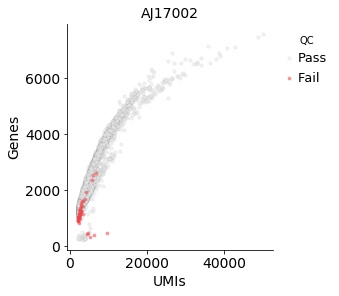

In [14]:
qc_figs2 = [sc.pl.qc_pass_fail(trial, return_fig=True) for trial in trials]

reading /fastscratch/seignm/singlecell/test_dataset/AJ17001/outs/raw_gene_bc_matrices_h5.h5 

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


(0:00:03.31)
reading /fastscratch/seignm/singlecell/test_dataset/AJ17002/outs/raw_gene_bc_matrices_h5.h5 

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


(0:00:03.64)


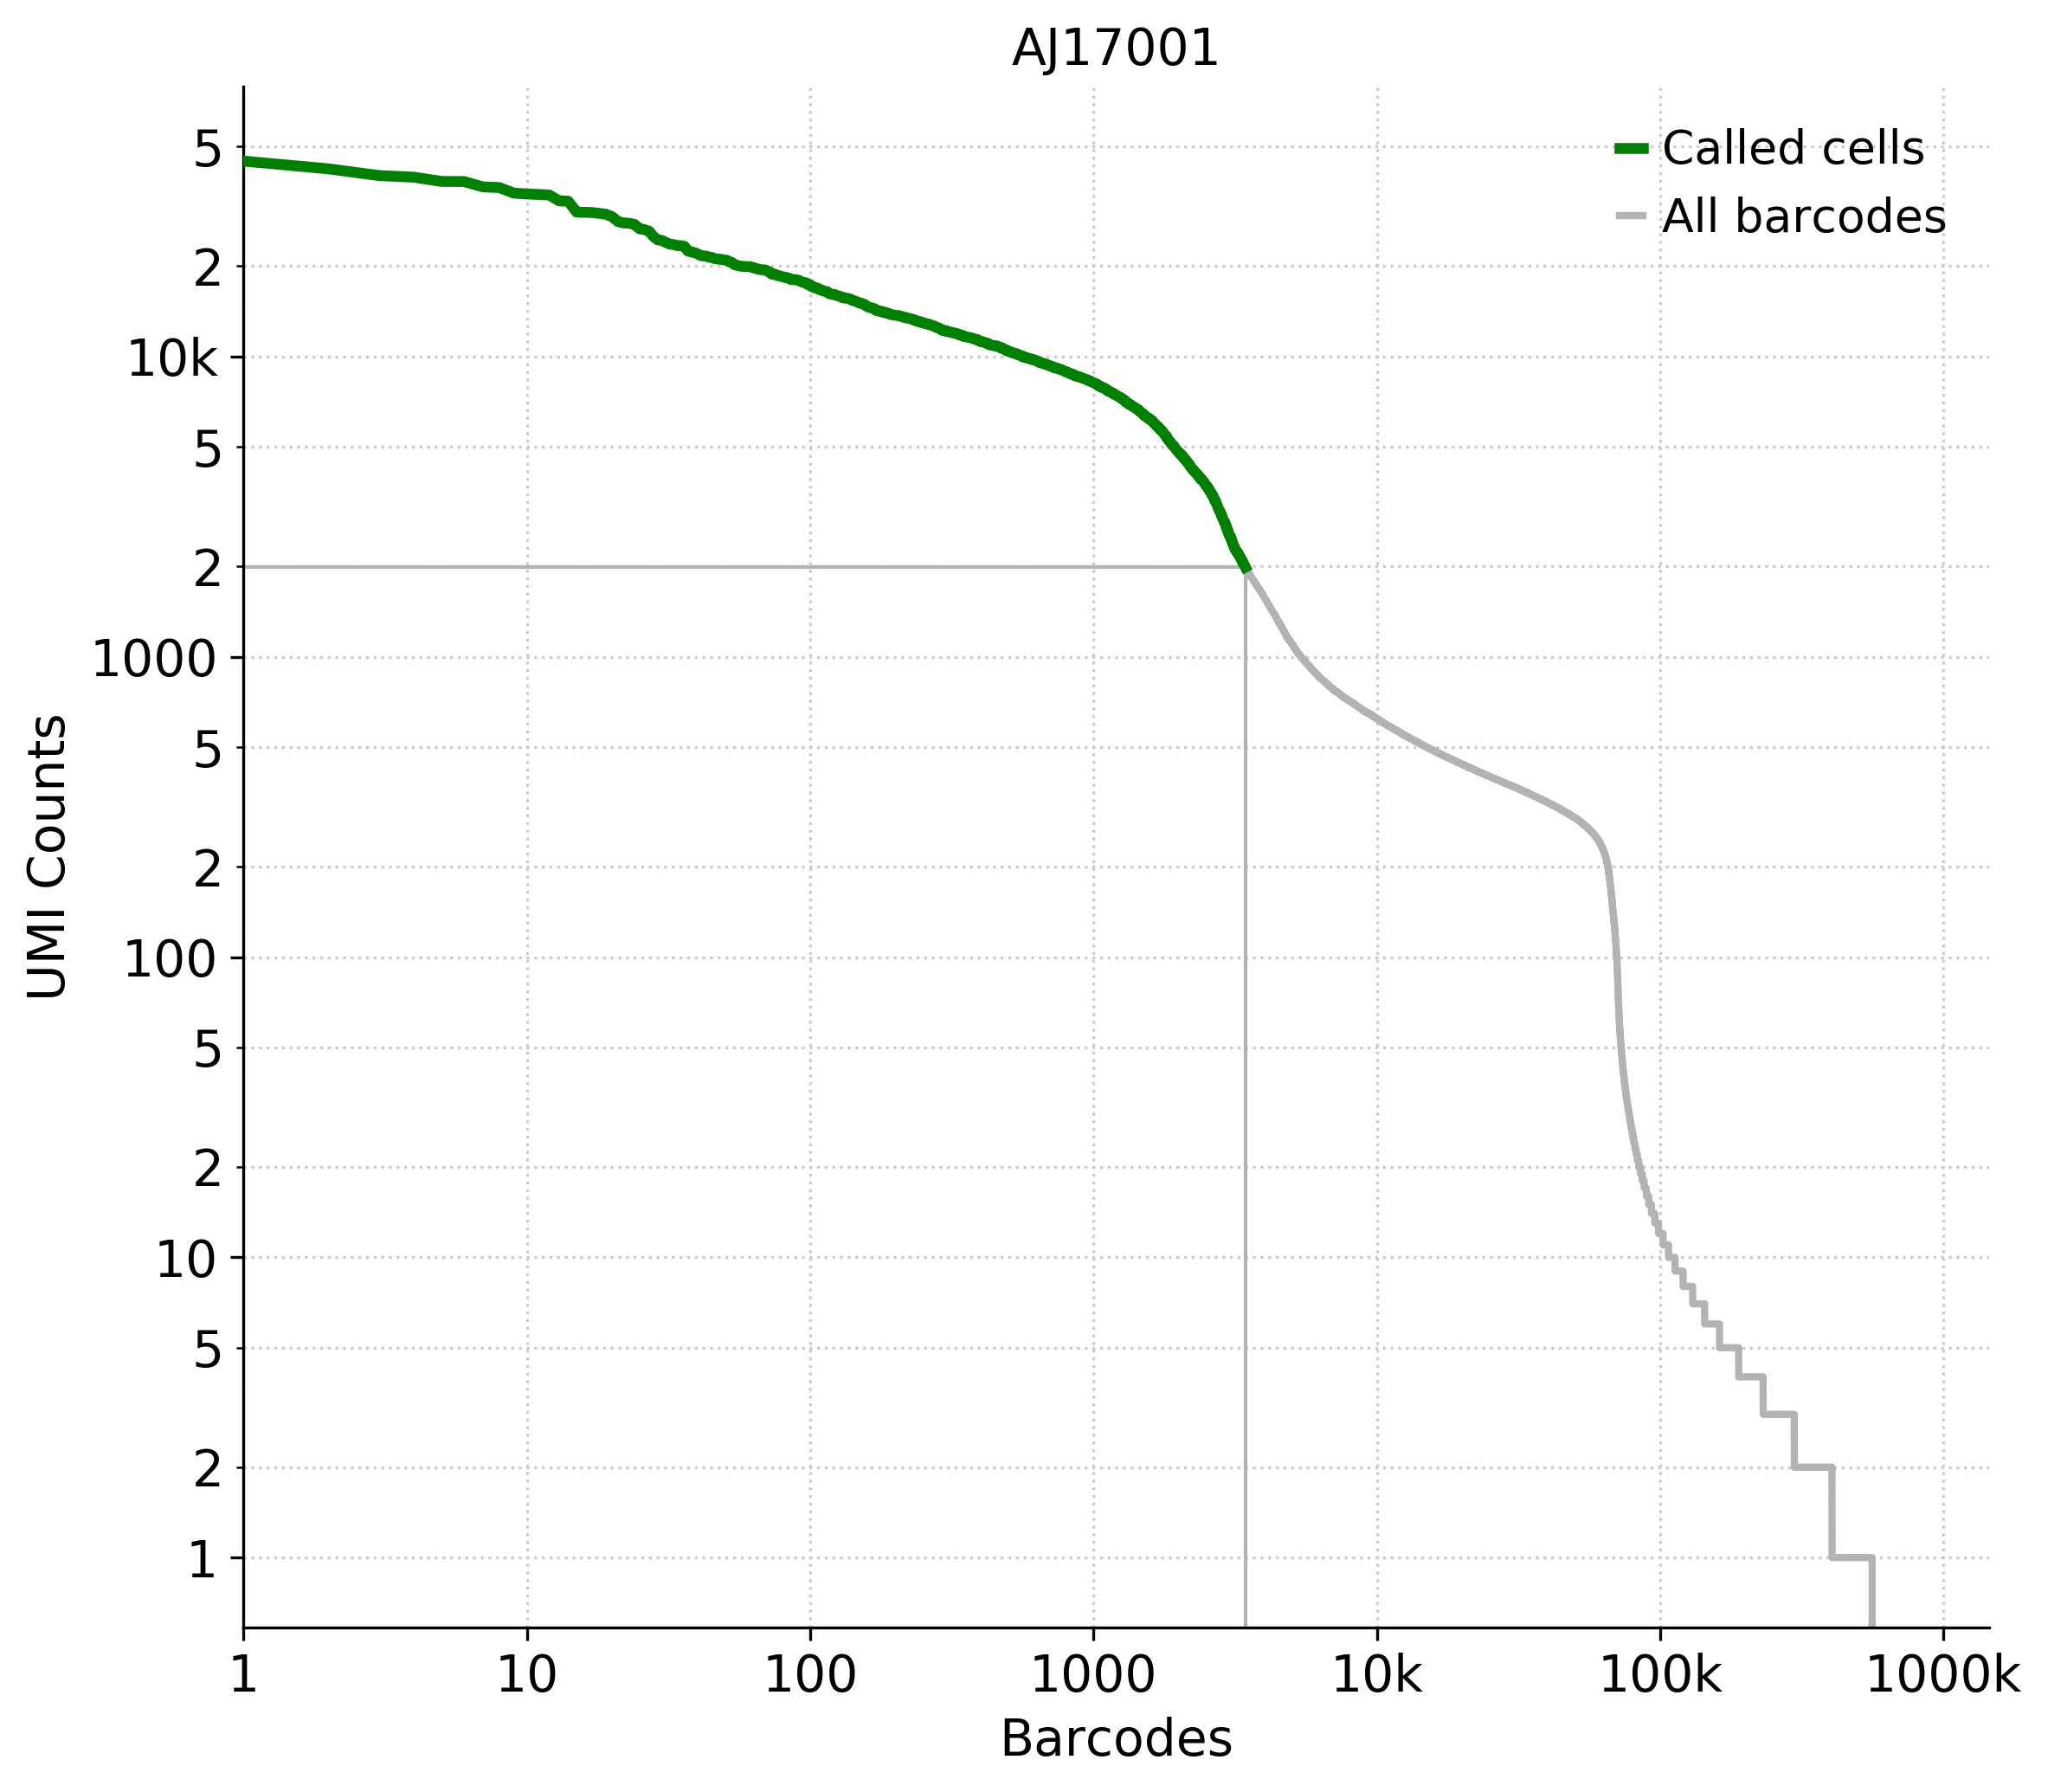

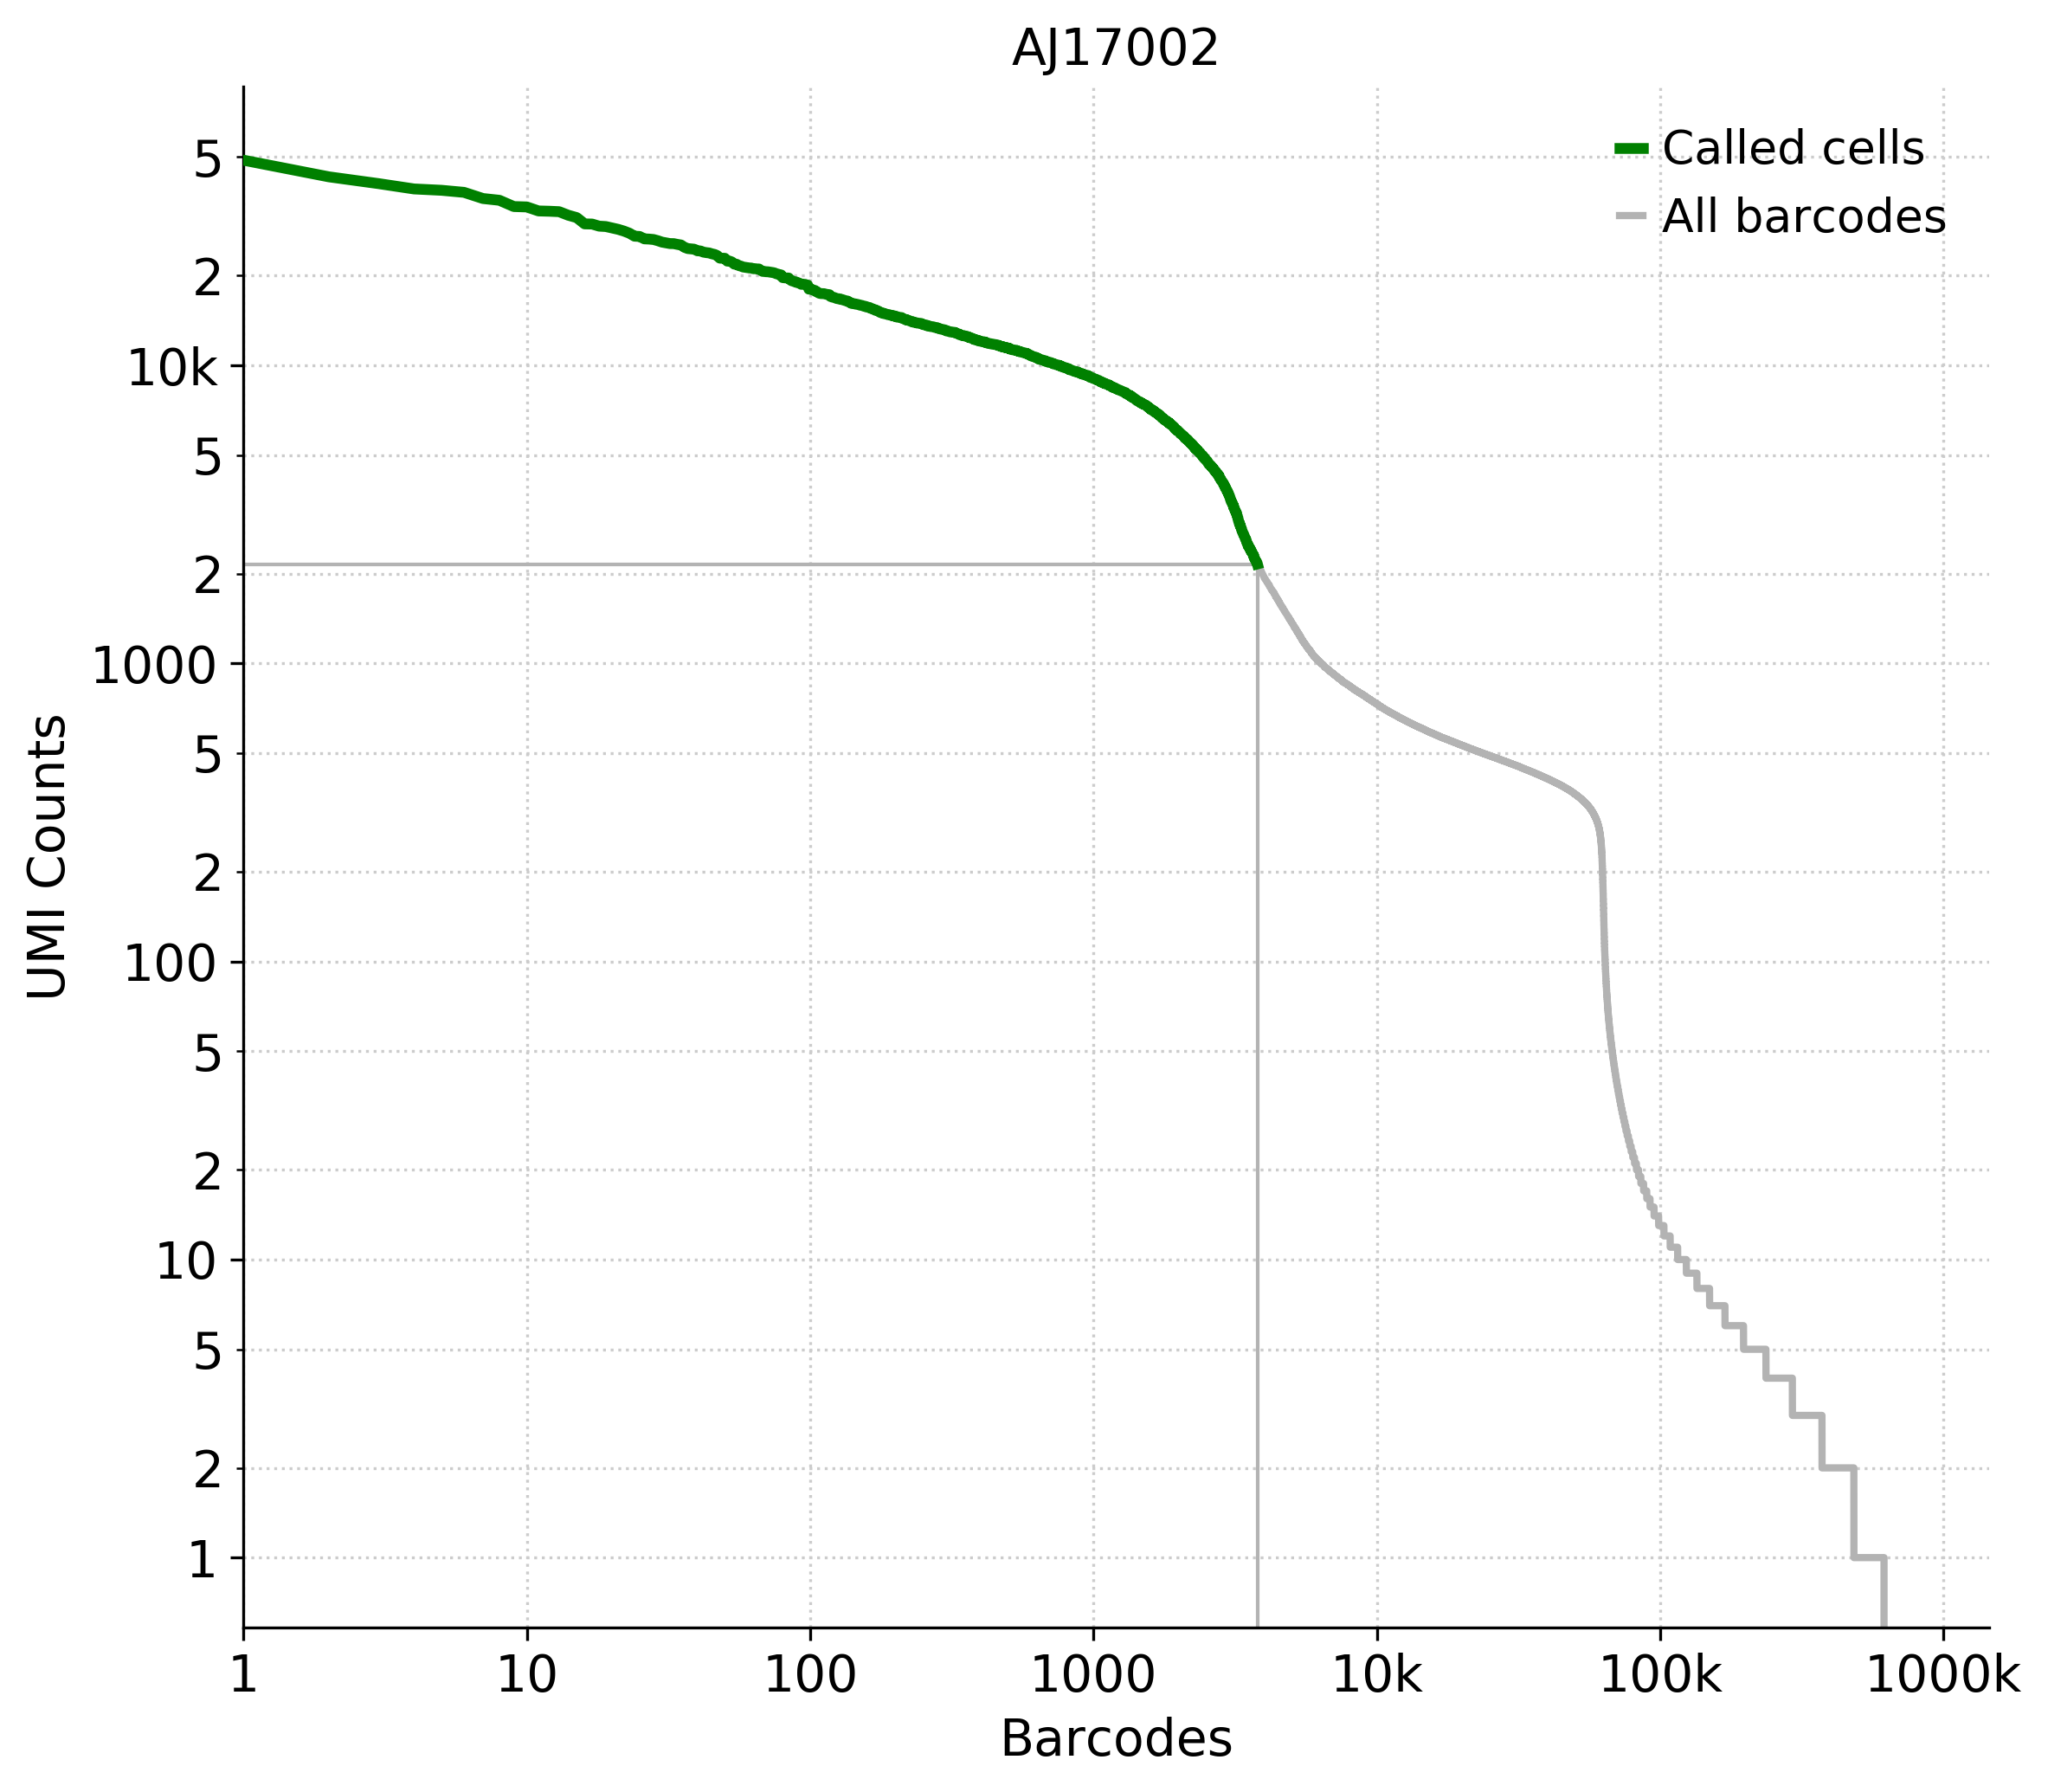

In [15]:
qc_fig3 = [sc.pl.umi_rank_plot(trial, return_fig=True) for trial in trials]

## Aggregation time
Now let's aggregate them together.

In [16]:
combined_qc = sc.aggregate(
    adata_qcs,
    combined_output_dir=combined_output_dir,
    combined_sample_name=combined_sample_name,
    combined_sampleid=combined_sampleid,
    make_output_dir=True,
    del_batch_var=False
)

In [17]:
combined_qc.shape

(7128, 17882)

You can see that the following keys are added to `.obs`:
* `batch`
* `sampleid`
* `sample_name`

The keys added to `.var` are pretty redundant:
* `gene_ids == gene_ids-0 == gene_ids-1 == ...`
* `n_counts = n_counts-0 + n_counts-1 + ...`
* `n_genes = n_genes-0 + n_genes-1 + ...`

I can envision how having the counts/genes on a per-sample basis could be useful, so these are left in by default, but all these extra `.var` keys can be removed by passing `del_batch_var=True`.

In [18]:
print("New `.obs` keys")
print(f"old: {adata_raws['AJ17001'].obs_keys()}\nnew: {combined_qc.obs_keys()}")
print("\nNew `.var` keys")
print(f"old: {adata_raws['AJ17001'].var_keys()}\nnew: {combined_qc.var_keys()}")

New `.obs` keys
old: ['sequencing_saturation', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mitochondrial', 'log1p_total_counts_mitochondrial', 'pct_counts_mitochondrial', 'total_counts_hemoglobin', 'log1p_total_counts_hemoglobin', 'pct_counts_hemoglobin']
new: ['batch', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_hemoglobin', 'log1p_total_counts_mitochondrial', 'n_genes_by_counts', 'pct_counts_hemoglobin', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pct_counts_in_top_50_genes', 'pct_counts_mitochondrial', 'sequencing_saturation', 'total_counts', 'total_counts_hemoglobin', 'total_counts_mitochondrial', 'sampleid', 'sample_name']

New `.var` keys
old: ['gene_ids', 'mitochondrial', 'hemoglobin', 'n_cells_by_counts', 'mean_counts', 'log1p_m

The `.uns` data also gets an overhaul.  Entries that describe this analysis remain the same, but others that describe per-sample data have now become nested dictionaries, accessible via sampleID, e.g.
```
In : combined_qc.uns["10x_metrics"].keys()
Out: dict_keys(['PR18016', 'PR18017'])
In : combined_qc.uns["qc_cell_filter"].keys()
Out: dict_keys(['PR18016', 'PR18017'])
```
Important entries like `sample_name` and `sampleid` have been replaced by the `combined_` versions defined during `sc.aggregate` and the previous per-sample versions are moved to `sample_names` and `sampleids`, respectively.

In [19]:
combined_qc.uns_keys()

['10x_chemistry',
 '10x_metrics',
 '10x_umi_cutoff',
 'analysis_pipeline_version',
 'analyst',
 'cellranger_reference_version',
 'cellranger_version',
 'customer_name',
 'date_created',
 'empty_genes',
 'genome',
 'input_dir',
 'input_file',
 'is_aggregation',
 'obs_titles',
 'output_dir',
 'principal_investigator_name',
 'qc_cell_filter',
 'qc_gene_filter',
 'qc_metrics',
 'raw_cells',
 'raw_genes',
 'report_schema_version',
 'sample_name',
 'sample_names',
 'sampleid',
 'sampleids',
 'species']

Everything from here continues **mostly** as usual.  Importantly, there is one additional key added to `.uns`:
```
In : combined_qc.uns["is_aggregation"]
Out: True
```
This signals to a few other methods to handle the sample differently.  For example, dimensionality reduction uses `bbknn` to construct the neighborhood graph and RDS saving will add an extra pseudogene denoting `batch`.

In [20]:
qc_save_file = sc.save_adata(combined_qc, "qc")

... storing 'sampleid' as categorical
... storing 'sample_name' as categorical


Saving AJ17001-AJ17002-qc_20190403.h5ad to /fastscratch/seignm/singlecell/test_output.


... storing 'gene_ids-0' as categorical
... storing 'mitochondrial-0' as categorical
... storing 'hemoglobin-0' as categorical
... storing 'gene_ids-1' as categorical
... storing 'mitochondrial-1' as categorical
... storing 'hemoglobin-1' as categorical


## HVG selection, dimensionality reduction, and clustering

In [21]:
adata_qc = sc.read_h5ad(qc_save_file)

In [22]:
adata_redux = sc.pp.preprocess(adata_qc, n_top_genes=1000, scale=True)

--> added
    'highly_variable', boolean vector (adata.var)
    'means', boolean vector (adata.var)
    'dispersions', boolean vector (adata.var)
    'dispersions_norm', boolean vector (adata.var)


In [23]:
sc.pp.dimensionality_reduction(adata_redux,
                               n_neighbors=10, min_dist=0.5)

computing batch balanced neighbors
    finished (0:00:07.80) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:18.32) --> added
    'X_umap', UMAP coordinates (adata.obsm)
computing UMAP
    finished (0:00:17.55) --> added
    'X_umap', UMAP coordinates (adata.obsm)
2D UMAP available at `.obsm['X_umap']`
3D UMAP available at `.obsm['X_umap_3d']`


We can visualize the aggregation by `"sample_name"`, `"sampleid"`, or `"batch"`!

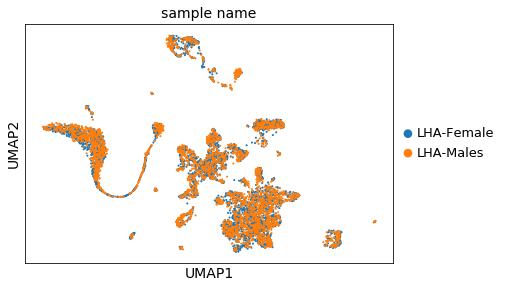

In [24]:
sc.pl.scatter(adata_redux, basis="umap", color="sample_name", show=False)

In [25]:
sc.tl.cluster(adata_redux, resolution=0.4)

running Leiden clustering
    finished (0:00:01.23) --> found 25 clusters and added
    'cluster', the cluster labels (adata.obs, categorical)


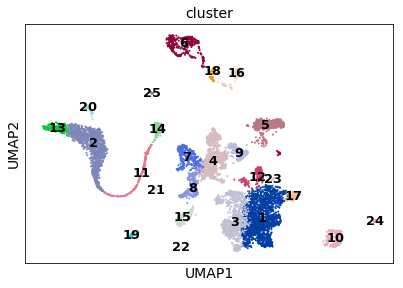

In [26]:
sc.pl.scatter(adata_redux, basis="umap", color="cluster", legend_loc="on data")

Visualize genes abundance with `"n_genes_by_counts"`, umis abundance with `"total_counts"` or visualize a specific gene's abundance with `["gene id"]`in all clusters 

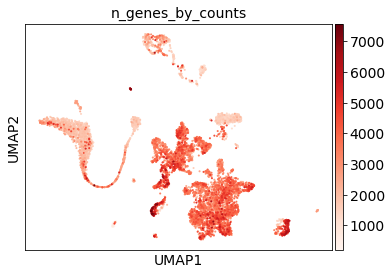

In [27]:
sc.pl.umap(adata_redux, color="n_genes_by_counts")

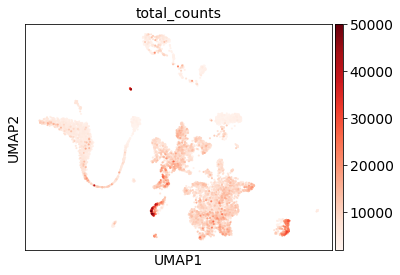

In [28]:
sc.pl.umap(adata_redux, color="total_counts")

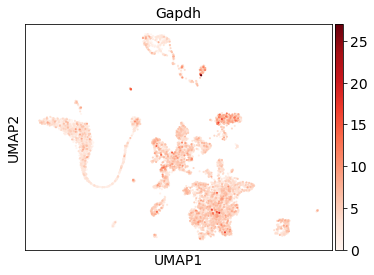

In [29]:
sc.pl.umap(adata_redux, color="Gapdh")

In [49]:
sc.tl.cluster(adata_redux, resolution=0.1)

running Leiden clustering
    finished (0:00:00.94) --> found 13 clusters and added
    'cluster', the cluster labels (adata.obs, categorical)


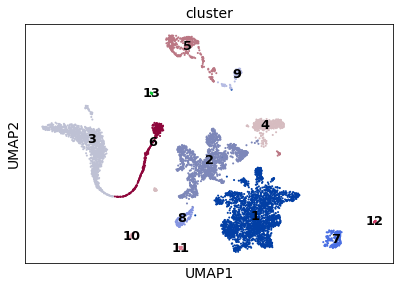

In [50]:
sc.pl.scatter(adata_redux, basis="umap", color="cluster", legend_loc="on data")

Splitting a cluster with `tl.subcluster()`. In the example below, we split `cluster "1"`.

In [51]:
sc.tl.subcluster(adata_redux, cluster="1", cluster_key="cluster", resolution=0.1)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.35) --> found 2 clusters and added
    'cluster_R1', the cluster labels (adata.obs, categorical)
Updated clusters under `adata_redux.obs['cluster_R1']`.


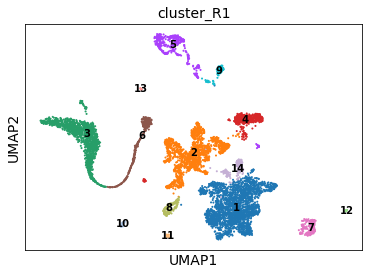

In [52]:
sc.pl.umap(adata_redux, color="cluster_R1", legend_loc="on data")

Merging clusters with `tl.combine_clusters`. 

In [53]:
sc.tl.combine_clusters(adata_redux, cluster_ids=["5", "9"], cluster_key="cluster_R1")

Updated clusters under `adata.obs['cluster_R1']`.


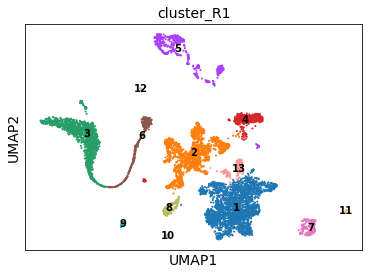

In [55]:
sc.pl.umap(adata_redux, color="cluster_R1", legend_loc="on data")

Re-oerder cluster numbers with `tl.reorder_clusters`. In this example, the very last clustering generated `"cluster_R1` was selected as final.

In [56]:
adata_redux.obs["cluster_R1"] = sc.tl.reorder_clusters(adata_redux.obs["cluster_R1"], [3, 6, 2, 8, 1, 13, 4, 12, 5, 9, 10, 7, 11])

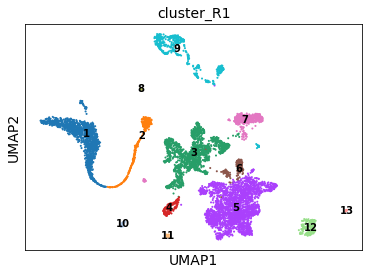

In [57]:
sc.pl.umap(adata_redux, color="cluster_R1", legend_loc="on data")

# Marker gene detection

In [59]:
markers = sc.tl.find_marker_genes(adata_redux, "cluster_R1", log_fold_change=1.0)

1 2 3 4 5 6 7 8 9 10 11 12 13 
Computed markers for 13 clusters.


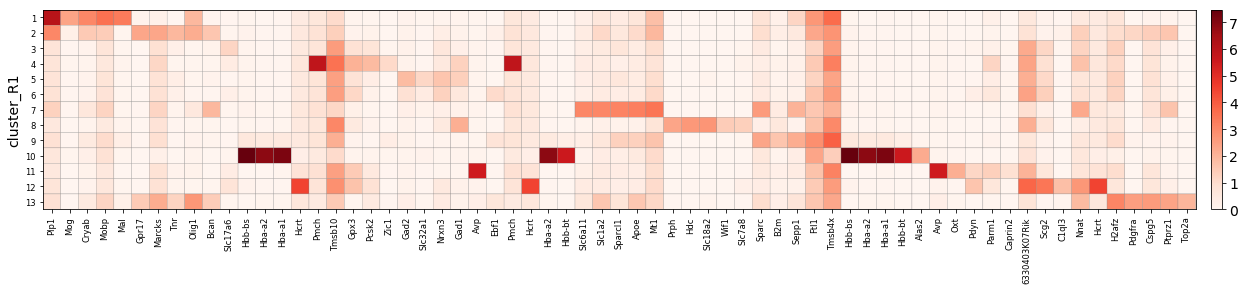

In [60]:
top5_genes = markers.groupby("cluster_R1").head(5).gene_name.values
sc.pl.matrixplot(adata_redux, top5_genes, groupby="cluster_R1", log=True)

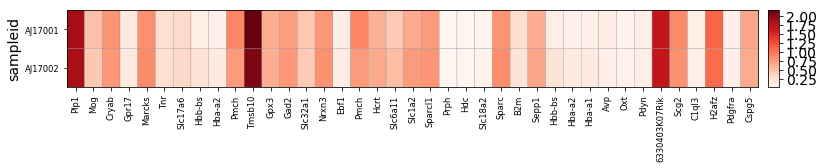

In [61]:
top3_genes = markers.groupby("cluster_R1").head(3).gene_name.values
sc.pl.matrixplot(adata_redux, top3_genes, groupby="sampleid", log=True)

## Saving outputs

In [62]:
sc.export_markers(adata_redux, "cluster_R1")

CSV file saved to [/fastscratch/seignm/singlecell/test_output/AJ17001-AJ17002_markers_20190403.csv].
Excel file saved to [/fastscratch/seignm/singlecell/test_output/AJ17001-AJ17002_markers_20190403.xlsx].


In [63]:
redux_save_file = sc.save_adata(adata_redux, "redux")

Saving AJ17001-AJ17002-redux_20190403.h5ad to /fastscratch/seignm/singlecell/test_output.


In [64]:
sc.save_adata_to_rds(adata_redux, cluster_key="cluster_R1")

Saved counts to /fastscratch/seignm/singlecell/test_output/AJ17001-AJ17002_counts.csv.
Saved features to /fastscratch/seignm/singlecell/test_output/AJ17001-AJ17002_features.csv.
Saved umap3d to /fastscratch/seignm/singlecell/test_output/AJ17001-AJ17002_umap3d.csv.
Rds creation submitted as pbs job 9568400.helix-master.
Output will be located in [/fastscratch/seignm/singlecell/test_output].


## Report generation

Report generation currently under construction for aggregated datasets.

In [65]:
report = sc.SCBLReport()

In [67]:
report.add_report_figures(
    adata_redux,
    violins=qc_figs,
    scatters=qc_figs2,
    ranks=qc_fig3,
    cluster_key="cluster_R1",
    batch_key="sample_name"
)

In [68]:
report.generate_report(adata_redux)

HTML report saved to [/fastscratch/seignm/singlecell/test_output/AJ17001-AJ17002_20190403_report.html].
